# Assignment 3: Recurrent Neural Networks for Stock Price Prediction

## Load Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

## Load and Preprocess

In [2]:
# Load the datasets
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

# Inspect the datasets
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB
None


In [3]:
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%m/%d/%Y')
train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(int)
print(train_data.info())

test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m/%d/%Y')
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(int)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 54.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Open    20 non-null     float64       
 2   High    20 non-null     float64       
 3   Low     20 non-null     float64       
 4   Close   20 non-null     float64       
 5   Volume  20 non-null     int32         
dtypes: datet

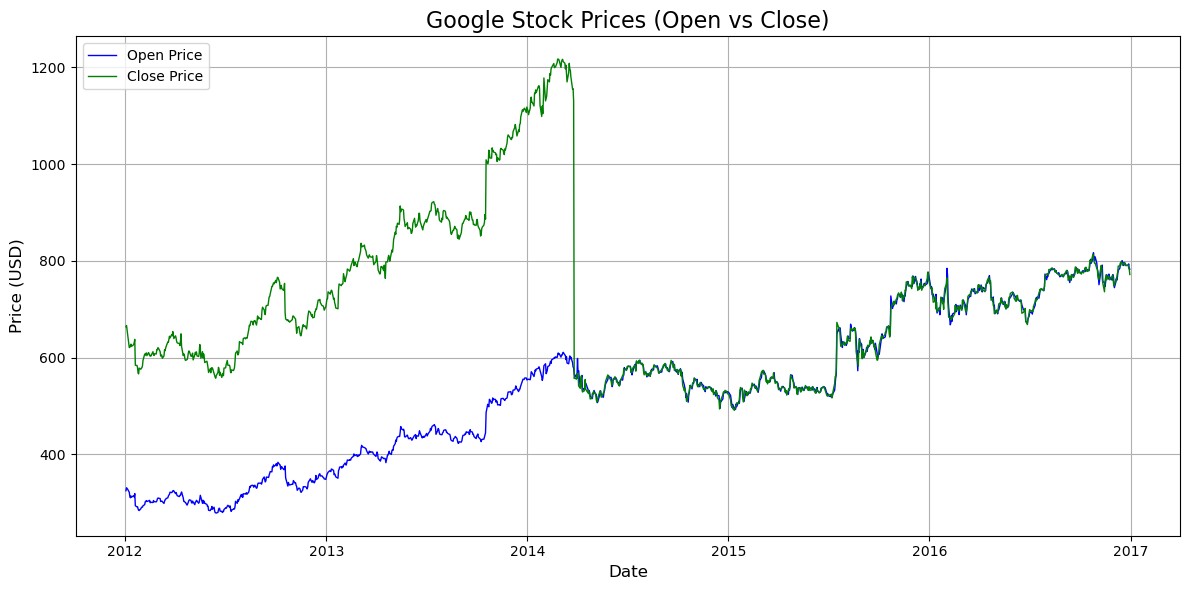

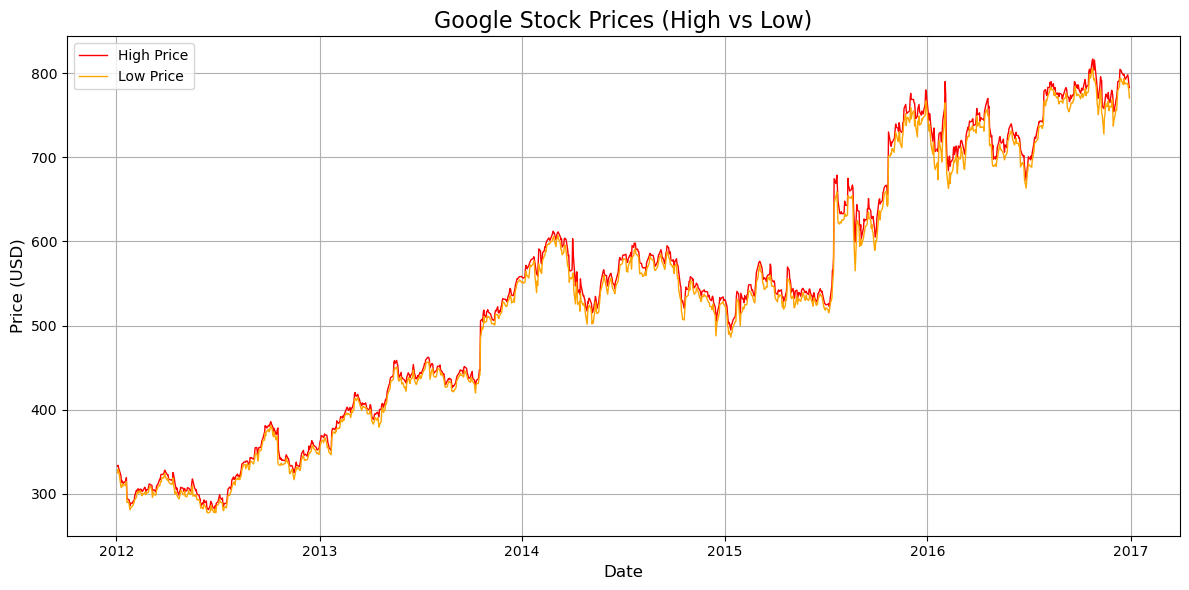

In [36]:
# Plot Open and Close prices
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Open'], label='Open Price', linewidth=1, color='blue')
plt.plot(train_data['Date'], train_data['Close'], label='Close Price', linewidth=1, color='green')
plt.title('Google Stock Prices (Open vs Close)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot High and Low prices
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['High'], label='High Price', linewidth=1, color='red')
plt.plot(train_data['Date'], train_data['Low'], label='Low Price', linewidth=1, color='orange')
plt.title('Google Stock Prices (High vs Low)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale 'Open', 'High', 'Low', 'Close', and 'Volume'
scaled_train_data = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test_data = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Volume']])

## Training and Testing

In [5]:
# Function to create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])  # Lookback window
        y.append(data[i, 1:3])        # Predict the 'High' and 'Low' prices
    return np.array(X), np.array(y)

In [6]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)  # Number of samples

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

In [8]:
lookback = 30
# Combine the last part of training data with test data for continuity if needed
combined_data = np.vstack((scaled_train_data[-lookback:], scaled_test_data))

# Create sequences for training, validation, and testing
X_train_full, y_train_full = create_sequences(scaled_train_data, lookback)
X_test, y_test = create_sequences(combined_data, lookback)

In [9]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

batch_size = 32
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 2
output_size = 2

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
patience = 5
counter = 0
num_epochs = 50
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store training loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Store validation loss

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/50], Train Loss: 0.0874, Val Loss: 0.0324
Epoch [2/50], Train Loss: 0.0114, Val Loss: 0.0037
Epoch [3/50], Train Loss: 0.0022, Val Loss: 0.0018
Epoch [4/50], Train Loss: 0.0015, Val Loss: 0.0015
Epoch [5/50], Train Loss: 0.0013, Val Loss: 0.0014
Epoch [6/50], Train Loss: 0.0014, Val Loss: 0.0014
Epoch [7/50], Train Loss: 0.0013, Val Loss: 0.0013
Epoch [8/50], Train Loss: 0.0011, Val Loss: 0.0013
Epoch [9/50], Train Loss: 0.0011, Val Loss: 0.0012
Epoch [10/50], Train Loss: 0.0012, Val Loss: 0.0012
Epoch [11/50], Train Loss: 0.0011, Val Loss: 0.0012
Epoch [12/50], Train Loss: 0.0011, Val Loss: 0.0011
Epoch [13/50], Train Loss: 0.0009, Val Loss: 0.0012
Epoch [14/50], Train Loss: 0.0010, Val Loss: 0.0013
Epoch [15/50], Train Loss: 0.0010, Val Loss: 0.0011
Epoch [16/50], Train Loss: 0.0012, Val Loss: 0.0011
Epoch [17/50], Train Loss: 0.0010, Val Loss: 0.0013
Epoch [18/50], Train Loss: 0.0011, Val Loss: 0.0011
Epoch [19/50], Train Loss: 0.0010, Val Loss: 0.0011
Epoch [20/50], Train 

In [12]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predicted, actual = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predicted.extend(outputs.cpu().numpy())  # Predictions for both 'High' and 'Low'
        actual.extend(y_batch.cpu().numpy())  # True values for 'High' and 'Low'

In [13]:
# Convert predicted and actual lists to numpy arrays
predicted = np.array(predicted)
actual = np.array(actual)

# Create a placeholder array with the same number of features as original data
n_samples = predicted.shape[0]
n_features = scaled_train_data.shape[1]  # Number of features (5)

# Initialize placeholder arrays for inverse transformation
predicted_full = np.zeros((n_samples, n_features))
actual_full = np.zeros((n_samples, n_features))

# Set the 'High' and 'Low' columns to the predicted and actual values
predicted_full[:, 1:3] = predicted
actual_full[:, 1:3] = actual

# Perform inverse transformation
predicted_full = scaler.inverse_transform(predicted_full)
actual_full = scaler.inverse_transform(actual_full)

# Extract only the 'High' and 'Low' columns after inverse transformation
predicted_high = predicted_full[:, 1]
predicted_low = predicted_full[:, 2]
actual_high = actual_full[:, 1]
actual_low = actual_full[:, 2]

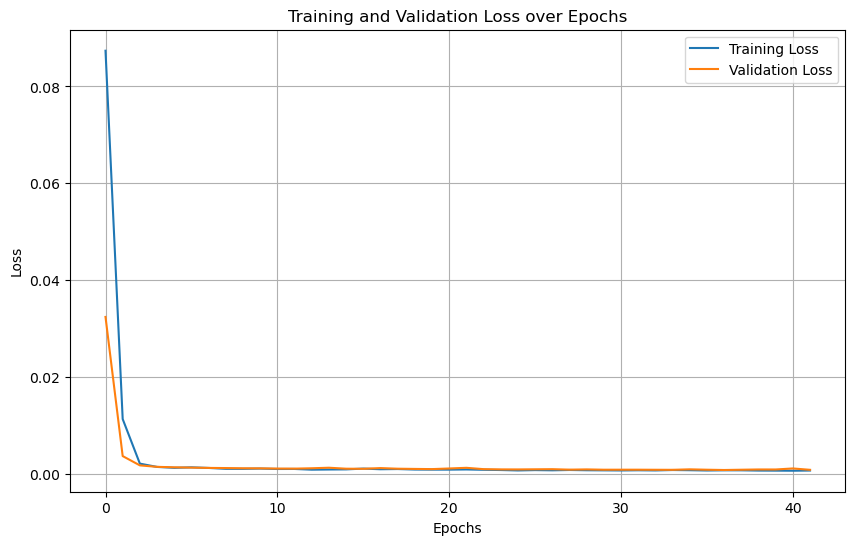

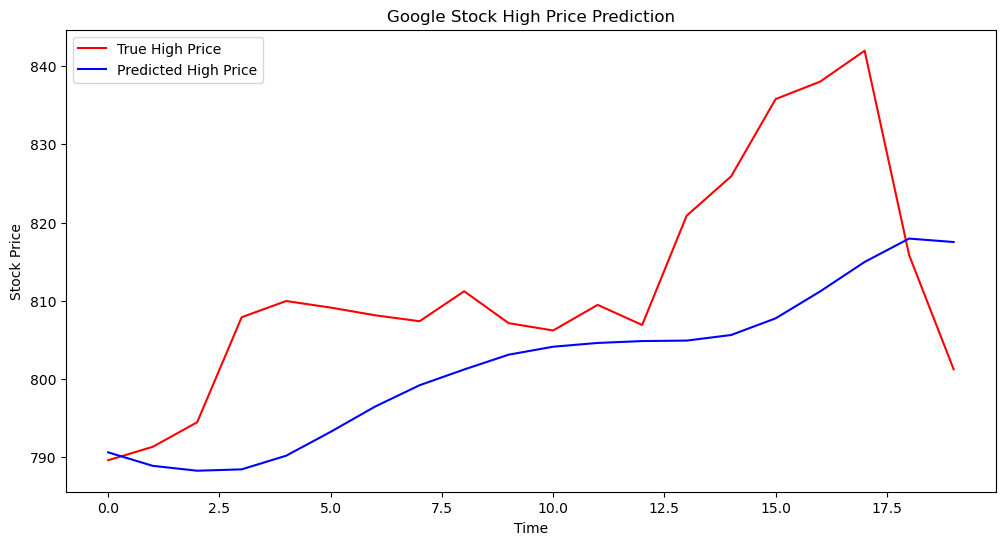

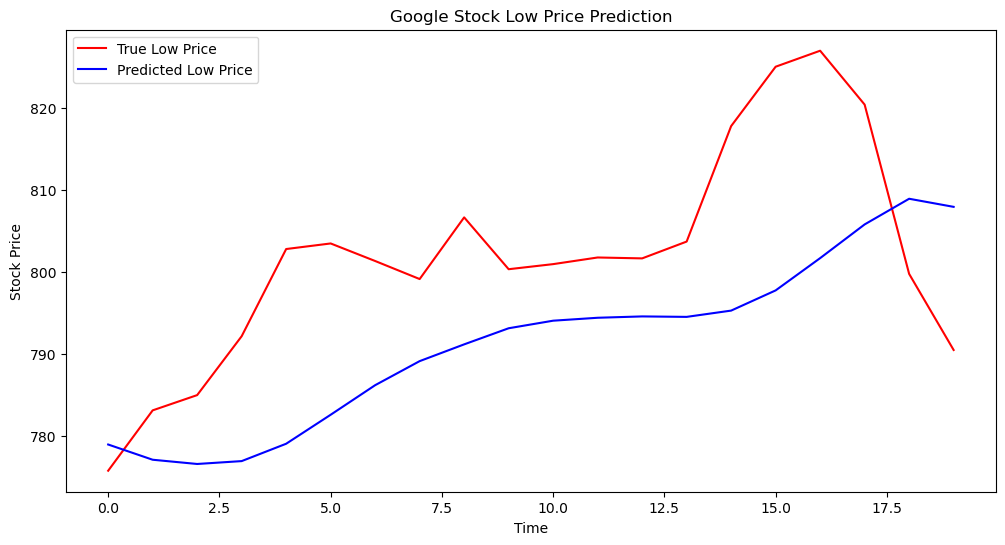

In [14]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for High and Low predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_high, color='red', label='True High Price')
plt.plot(predicted_high, color='blue', label='Predicted High Price')
plt.title('Google Stock High Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(actual_low, color='red', label='True Low Price')
plt.plot(predicted_low, color='blue', label='Predicted Low Price')
plt.title('Google Stock Low Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [15]:
# Calculate metrics for High and Low predictions
mae_high = mean_absolute_error(actual_high, predicted_high)
rmse_high = np.sqrt(mean_squared_error(actual_high, predicted_high))
print(f"High Price - MAE: {mae_high:.4f}, RMSE: {rmse_high:.4f}")

mae_low = mean_absolute_error(actual_low, predicted_low)
rmse_low = np.sqrt(mean_squared_error(actual_low, predicted_low))
print(f"Low Price - MAE: {mae_low:.4f}, RMSE: {rmse_low:.4f}")

High Price - MAE: 12.1968, RMSE: 15.1360
Low Price - MAE: 13.6043, RMSE: 15.3249


## Hyperparameter Tuning

In [16]:
learning_rates = [0.001, 0.01, 0.0001]
batch_sizes = [16, 32, 64]
lookback_periods = [10, 20, 30]
hidden_units = [32, 50, 100]

In [17]:
best_params = None
best_val_loss = float('inf')

for lr, batch_size, lookback, hidden_size in itertools.product(learning_rates, batch_sizes, lookback_periods, hidden_units):
    
    # Prepare the dataset with the current lookback period
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i])
            y.append(data[i, 0])  # Predict the 'Open' price
        return np.array(X), np.array(y)

    scaled_train_data = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])
    X_train_full, y_train_full = create_sequences(scaled_train_data, lookback)

    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Define dataset and dataloader
    train_dataset = StockDataset(X_train, y_train)
    val_dataset = StockDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define the model with the current hidden size
    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            out = self.fc(out[:, -1, :])  # Use the output from the last time step
            return out

    input_size = X_train.shape[2]
    output_size = 1
    num_layers = 2

    # Initialize model, loss function, and optimizer
    model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    num_epochs = 20  # You could reduce this for a quick grid search
    patience = 3
    counter = 0
    best_epoch_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early stopping
        if val_loss < best_epoch_val_loss:
            best_epoch_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    # Compare current model's validation loss with the best seen so far
    if best_epoch_val_loss < best_val_loss:
        best_val_loss = best_epoch_val_loss
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'lookback': lookback,
            'hidden_size': hidden_size
        }

    print(f"Combination: LR={lr}, Batch Size={batch_size}, Lookback={lookback}, Hidden Units={hidden_size}, Val Loss={best_epoch_val_loss:.4f}")

print(f"Best Hyperparameters: {best_params}, Best Validation Loss: {best_val_loss:.4f}")

Combination: LR=0.001, Batch Size=16, Lookback=10, Hidden Units=32, Val Loss=0.0009
Combination: LR=0.001, Batch Size=16, Lookback=10, Hidden Units=50, Val Loss=0.0007
Combination: LR=0.001, Batch Size=16, Lookback=10, Hidden Units=100, Val Loss=0.0006
Combination: LR=0.001, Batch Size=16, Lookback=20, Hidden Units=32, Val Loss=0.0008
Combination: LR=0.001, Batch Size=16, Lookback=20, Hidden Units=50, Val Loss=0.0007
Combination: LR=0.001, Batch Size=16, Lookback=20, Hidden Units=100, Val Loss=0.0008
Combination: LR=0.001, Batch Size=16, Lookback=30, Hidden Units=32, Val Loss=0.0011
Combination: LR=0.001, Batch Size=16, Lookback=30, Hidden Units=50, Val Loss=0.0008
Combination: LR=0.001, Batch Size=16, Lookback=30, Hidden Units=100, Val Loss=0.0009
Combination: LR=0.001, Batch Size=32, Lookback=10, Hidden Units=32, Val Loss=0.0010
Combination: LR=0.001, Batch Size=32, Lookback=10, Hidden Units=50, Val Loss=0.0009
Combination: LR=0.001, Batch Size=32, Lookback=10, Hidden Units=100, Val 

In [26]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32),
        )

In [27]:
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i, 1:3])
    return np.array(X), np.array(y)

In [33]:
lookback = 20
combined_data = np.vstack((scaled_train_data[-lookback:], scaled_test_data))
X_train_full, y_train_full = create_sequences(scaled_train_data, lookback)
X_test, y_test = create_sequences(combined_data, lookback)


X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
batch_size = 32
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]  # Number of features
hidden_size = 100
num_layers = 2
output_size = 2
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


patience = 5
counter = 0
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/50], Train Loss: 0.0816, Val Loss: 0.0018
Epoch [2/50], Train Loss: 0.0015, Val Loss: 0.0014
Epoch [3/50], Train Loss: 0.0010, Val Loss: 0.0011
Epoch [4/50], Train Loss: 0.0009, Val Loss: 0.0007
Epoch [5/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [6/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [7/50], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [8/50], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [9/50], Train Loss: 0.0010, Val Loss: 0.0006
Epoch [10/50], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [11/50], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [12/50], Train Loss: 0.0007, Val Loss: 0.0010
Epoch [13/50], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [14/50], Train Loss: 0.0007, Val Loss: 0.0005
Epoch [15/50], Train Loss: 0.0007, Val Loss: 0.0005
Epoch [16/50], Train Loss: 0.0005, Val Loss: 0.0005
Epoch [17/50], Train Loss: 0.0007, Val Loss: 0.0004
Epoch [18/50], Train Loss: 0.0007, Val Loss: 0.0004
Epoch [19/50], Train Loss: 0.0005, Val Loss: 0.0005
Epoch [20/50], Train 

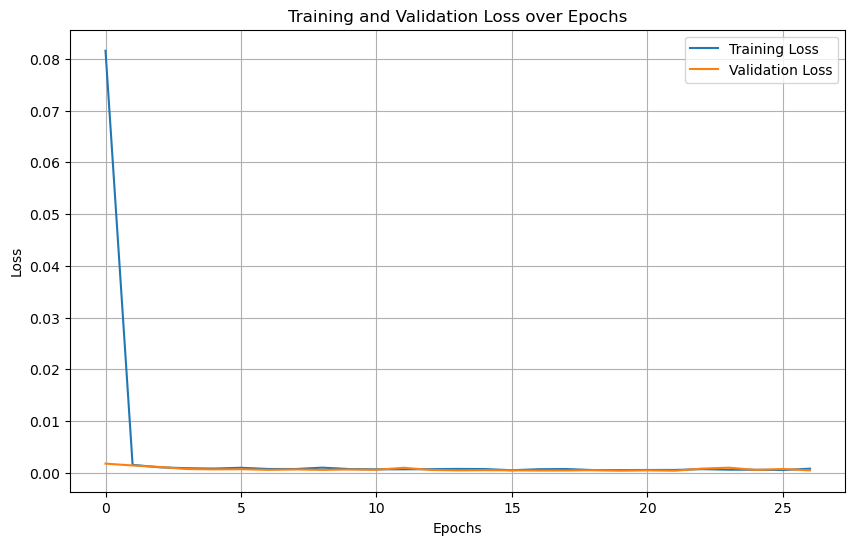

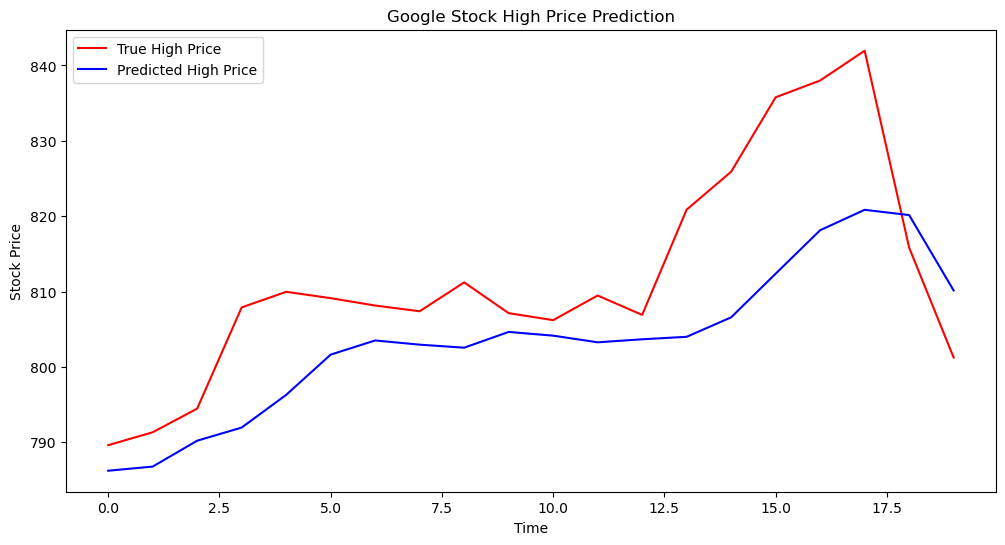

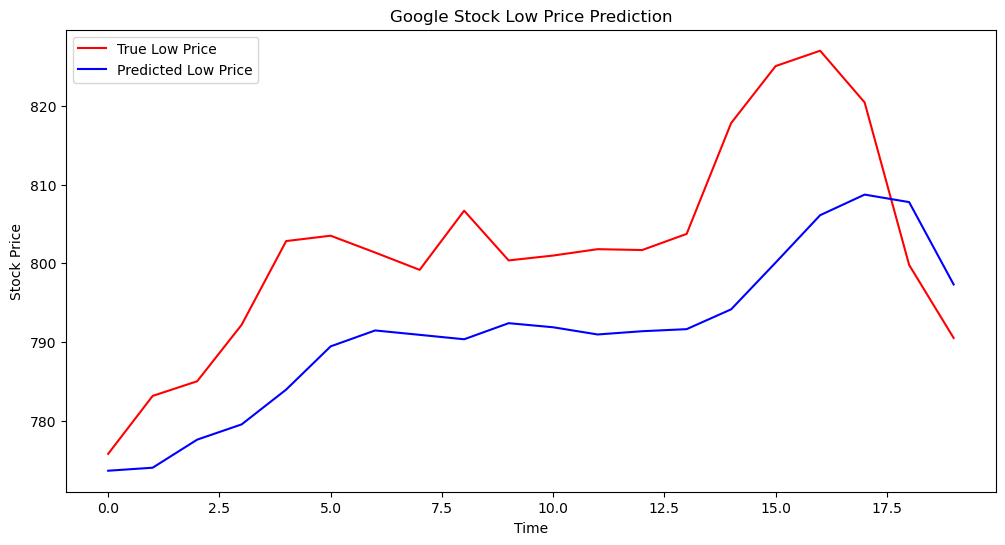

High Price - MAE: 9.7380, RMSE: 11.9691
Low Price - MAE: 12.2543, RMSE: 13.5515


In [34]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predicted, actual = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predicted.extend(outputs.cpu().numpy())
        actual.extend(y_batch.cpu().numpy())

# Convert predicted and actual lists to numpy arrays
predicted = np.array(predicted)
actual = np.array(actual)

# Create a placeholder array with the same number of features as original data
n_samples = predicted.shape[0]
n_features = scaled_train_data.shape[1]  # Number of features (5)

# Initialize placeholder arrays for inverse transformation
predicted_full = np.zeros((n_samples, n_features))
actual_full = np.zeros((n_samples, n_features))

# Set the 'High' and 'Low' columns to the predicted and actual values
predicted_full[:, 1:3] = predicted
actual_full[:, 1:3] = actual

# Perform inverse transformation
predicted_full = scaler.inverse_transform(predicted_full)
actual_full = scaler.inverse_transform(actual_full)

# Extract only the 'High' and 'Low' columns after inverse transformation
predicted_high = predicted_full[:, 1]
predicted_low = predicted_full[:, 2]
actual_high = actual_full[:, 1]
actual_low = actual_full[:, 2]


# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for High and Low predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_high, color='red', label='True High Price')
plt.plot(predicted_high, color='blue', label='Predicted High Price')
plt.title('Google Stock High Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(actual_low, color='red', label='True Low Price')
plt.plot(predicted_low, color='blue', label='Predicted Low Price')
plt.title('Google Stock Low Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Calculate metrics for High and Low predictions
mae_high = mean_absolute_error(actual_high, predicted_high)
rmse_high = np.sqrt(mean_squared_error(actual_high, predicted_high))
print(f"High Price - MAE: {mae_high:.4f}, RMSE: {rmse_high:.4f}")

mae_low = mean_absolute_error(actual_low, predicted_low)
rmse_low = np.sqrt(mean_squared_error(actual_low, predicted_low))
print(f"Low Price - MAE: {mae_low:.4f}, RMSE: {rmse_low:.4f}")